In [8]:
import pandas as pd
import numpy as np
df = pd.read_csv('loan_features.csv')
df.head()

,Unnamed: 0,LOAN_AMOUNT,STATUS,num_Borrowers,pictured,is_ENG,Agriculture,Arts,Clothing,Construction,...,NA,OC,SA,Arabic,English,French,Indonesian,Portuguese,Russian,Spanish
0,0,825.0,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,525.0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,400.0,1,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,3,225.0,1,1,1,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4,1575.0,1,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
ss = StandardScaler()
y= df.STATUS
X = df.drop('STATUS',axis = 1)
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
counter = Counter(y_train)
print(counter)
X_train, y_train = pipeline.fit_resample(X_train, y_train)
counter = Counter(y_train)
print(counter)
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)

Counter({1: 1290778, 0: 62882})
Counter({1: 258154, 0: 129077})


In [42]:
#train Random Forest & XGBoost models
from numpy import loadtxt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state=0,learning_rate=.1,scale_pos_weight = np.sqrt(y_train.value_counts()[0]/y_train.value_counts()[1]));
xgb.fit(X_train, y_train);
rf = RandomForestClassifier(random_state = 0);
rf.fit(X_train, y_train);

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:12:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


              precision    recall  f1-score   support

    Unfunded       0.10      0.50      0.16     20993
      Funded       0.97      0.77      0.86    430228

    accuracy                           0.76    451221
   macro avg       0.53      0.64      0.51    451221
weighted avg       0.93      0.76      0.83    451221



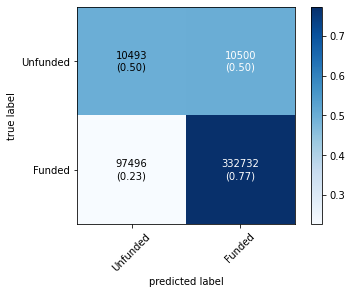

In [44]:
#RF Model Assessment
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
target_names = ['Unfunded','Funded']
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = True,
                                   class_names = target_names,

                                   show_normed = True,
                                   colorbar = True)

              precision    recall  f1-score   support

    Unfunded       0.15      0.66      0.24     20993
      Funded       0.98      0.82      0.89    430228

    accuracy                           0.81    451221
   macro avg       0.56      0.74      0.57    451221
weighted avg       0.94      0.81      0.86    451221



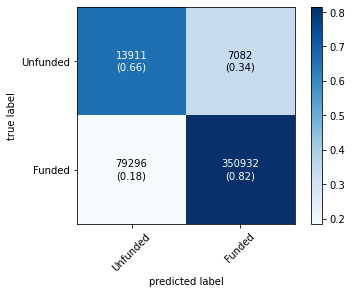

In [45]:
#XGBoost Model Assessment
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
target_names = ['Unfunded','Funded']
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred, labels=xgb.classes_)
figure, ax = plot_confusion_matrix(conf_mat = cm,
                                   show_absolute = True,
                                   class_names = target_names,

                                   show_normed = True,
                                   colorbar = True)

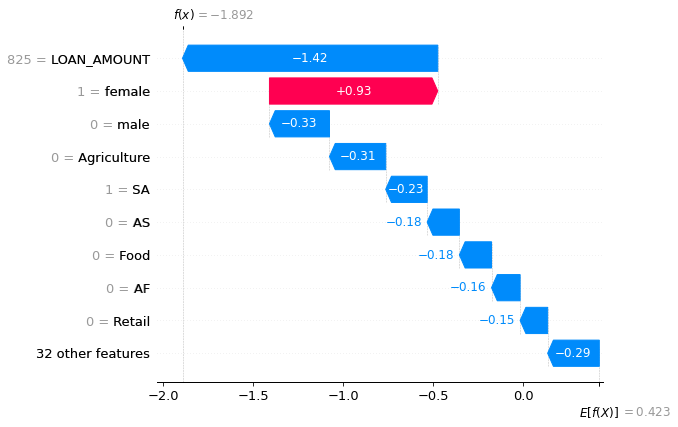

In [46]:
import shap
explainer = shap.Explainer(xgb)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])